In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from collections import defaultdict

from imblearn.over_sampling import SMOTE
import scispacy
import spacy
from spacy import displacy
import en_ner_jnlpba_md
import en_core_sci_sm
import en_ner_bionlp13cg_md
import en_ner_bc5cdr_md
import random

In [2]:
data_df = pd.read_csv('./datasets/mtsamples.csv').set_index(['index'])
data_df

,description,medical_specialty,sample_name,transcription,keywords
index,,,,,
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN


In [4]:
# combining all the strings together for cleaning
str_series = data_df['description']+data_df['medical_specialty']+data_df['sample_name']+data_df['transcription']
concat_df = pd.DataFrame({'med_str':str_series,'labels': data_df['keywords']})
concat_df

,med_str,labels
index,,
0,A 23-year-old white female presents with comp...,"allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler. Cardiovascular / Pulmo...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram Cardiovascular / Pulmonary...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,Patient having severe sinusitis about two to ...,NaN
4995,This is a 14-month-old baby boy Caucasian who...,"allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,NaN


In [5]:
#checking for na values

concat_df.isna().sum()

med_str      33
labels     1068
dtype: int64

In [6]:
# dropping null values from combined list of medical strings

concat_df2 = concat_df.dropna(subset=['med_str'])

concat_df2

,med_str,labels
index,,
0,A 23-year-old white female presents with comp...,"allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler. Cardiovascular / Pulmo...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram Cardiovascular / Pulmonary...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,Patient having severe sinusitis about two to ...,NaN
4995,This is a 14-month-old baby boy Caucasian who...,"allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,NaN


In [7]:
#checking for duplicates
concat_df2['med_str'].duplicated().sum()

0

In [8]:
#setting all to lower case

concat_df2['med_str'] = concat_df2['med_str'].apply(str.lower)

/Users/user_1/opt/anaconda3/envs/spacy36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#checking for hyper links

display(concat_df2['med_str'].str.extract('(www\S+)').value_counts())
display(concat_df2['med_str'].str.extract('(http\S+)').value_counts())

Series([], dtype: int64)

Series([], dtype: int64)

In [10]:
#filter out punctuation

display(concat_df2['med_str'].str.extract(r'([^\w\s])').value_counts())

concat_df3 = concat_df2.copy()

concat_df3['med_str'] = concat_df2['med_str'].str.replace(r'([^\w\s])',' ')
concat_df3['med_str'] = concat_df3['med_str'].str.replace(r'(_)', ' ')


.    2153
,    1256
-    1154
(     150
/     100
:      46
&      46
'      22
#      18
;       7
%       5
+       4
"       4
?       1
dtype: int64

In [11]:
# filter out single digit numbers

display(concat_df3['med_str'].str.extract(r'(\d+)').value_counts())

concat_df4 = concat_df3.copy()

concat_df4['med_str'] = concat_df3['med_str'].str.replace('(\d+)','')

1        1238
2         478
3         295
4         247
5         240
         ... 
136         1
425         1
900         1
724         1
57307       1
Length: 162, dtype: int64

In [12]:
#filter out lone letters

concat_df5 = concat_df4.copy()

concat_df5['med_str'] = concat_df4['med_str'].str.replace(r'(\b[a-zA-Z]\b)','')

concat_df5

,med_str,labels
index,,
0,year old white female presents with complai...,"allergy / immunology, allergic rhinitis, aller..."
1,consult for laparoscopic gastric bypass bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,consult for laparoscopic gastric bypass bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,mode doppler cardiovascular pulmonar...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,echocardiogram cardiovascular pulmonary ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,patient having severe sinusitis about two to ...,NaN
4995,this is month old baby boy caucasian who ca...,"allergy / immunology, mucous membranes, conjun..."
4996,female for complete physical and follow up ...,NaN


In [24]:
# def generate_dict(text_col):

#     '''Count number of words, sentences and generate a dictionary of all words'''

#     sent_count = 0
#     word_count = 0
#     vocab = defaultdict(lambda:0)
#     for text in text_col:
#         sentences=sent_tokenize(str(text).lower())
#         sent_count = sent_count + len(sentences)
#         for sentence in sentences:
#             words=word_tokenize(sentence)

#             for word in words:
#                 vocab[word]+=1

#     word_count = len(vocab.keys())
#     return sent_count,word_count,vocab

# sent_count,word_count,vocab= generate_dict(concat_df5['med_str'].tolist())

# display(sent_count,word_count,vocab)

4966

21058

defaultdict(<function __main__.generate_dict.<locals>.<lambda>()>,
            {'year': 4000,
             'old': 4051,
             'white': 1177,
             'female': 1777,
             'presents': 633,
             'with': 38577,
             'complaint': 723,
             'of': 62901,
             'allergies': 1479,
             'allergy': 132,
             'immunology': 13,
             'allergic': 266,
             'rhinitis': 115,
             'subjective': 281,
             'this': 14156,
             'she': 17935,
             'used': 3606,
             'to': 51989,
             'have': 5008,
             'when': 1443,
             'lived': 30,
             'in': 33559,
             'seattle': 8,
             'but': 4286,
             'thinks': 81,
             'they': 1236,
             'are': 6319,
             'worse': 328,
             'here': 526,
             'the': 153012,
             'past': 2746,
             'has': 11308,
             'tried': 155,
             'c

In [13]:
# Extract our default stopwords from CountVectorizer

stop_words = CountVectorizer(stop_words= 'english').get_stop_words()

stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [14]:
#adding extra stop words

new_stop_words = []

for word in stop_words:
    new_stop_words.append(word)

new_stop_words.extend(['en','wa','ha'])

new_stop_words

['bill',
 'without',
 'often',
 'across',
 'upon',
 'whether',
 'an',
 'might',
 'twenty',
 'whole',
 'eg',
 'ours',
 'done',
 'they',
 'system',
 'whereby',
 'she',
 're',
 'against',
 'many',
 'me',
 'where',
 'sincere',
 'own',
 'almost',
 'became',
 'detail',
 'become',
 'above',
 'how',
 'since',
 'nothing',
 'anyway',
 'over',
 'your',
 'we',
 'who',
 'show',
 'again',
 'some',
 'whatever',
 'yourself',
 'de',
 'around',
 'never',
 'if',
 'un',
 'first',
 'myself',
 'moreover',
 'noone',
 'thick',
 'on',
 'anyone',
 'her',
 'through',
 'describe',
 'someone',
 'so',
 'as',
 'though',
 'such',
 'five',
 'mine',
 'of',
 'former',
 'hereby',
 'whence',
 'he',
 'very',
 'the',
 'few',
 'although',
 'everyone',
 'now',
 'every',
 'already',
 'everything',
 'give',
 'out',
 'which',
 'becoming',
 'neither',
 'meanwhile',
 'towards',
 'wherever',
 'cry',
 'same',
 'couldnt',
 'via',
 'anywhere',
 'were',
 'whither',
 'somehow',
 'then',
 'whom',
 'within',
 'had',
 'except',
 'other',
 

In [15]:
# # generating our vocab for all texts

# vocab_2 = [w for w in vocab.keys() if w not in new_stop_words]

# vocab_2

In [16]:
def lemmatize_sent(sent):

    '''Function for lemmatizing sentences'''
    
    word_list = word_tokenize(sent)

    lemma = WordNetLemmatizer()

    lemma_list = ' '.join([lemma.lemmatize(w) for w in word_list if w not in new_stop_words])

    return lemma_list

In [17]:
# lemmatize sentences

concat_df6 = concat_df5.copy()
concat_df6['med_str'] = concat_df5['med_str'].map(lemmatize_sent)
concat_df6['med_str'][1]

In [18]:
lemma_dict = {}

class StringTokenizer(object):

    '''This function is atcivated when we fit into cvec fit transform. it will create a lemma_dict'''

    def __init__(self):

        self.lem = WordNetLemmatizer()
        
    def __call__(self,object):

        for w in word_tokenize(object):

            lemma_dict[w] = self.lem.lemmatize(w)

        lemma_list = [self.lem.lemmatize(w) for w in word_tokenize(object)]
        
        return lemma_list

In [19]:
# # we want to generate lemmatize dictionary

# cvec = CountVectorizer(stop_words = new_stop_words,
# tokenizer = StringTokenizer(),)

# concat_cvec = pd.DataFrame(cvec.fit_transform(concat_df5['med_str']).todense(),columns = cvec.get_feature_names())

# concat_cvec.index.rename('index',inplace=True)

In [20]:
# initiating med spacy dictionaries

med_nlp = en_ner_bionlp13cg_md.load()

#nlp = spacy.load("en_ner_bionlp13cg_md")

#nlp = spacy.load("en_ner_jnlpba_md")
#nlp = en_ner_jnlpba_md.load()

In [21]:
# doing iob tagging and entity labelling

def entity_table(df):

    i = 0

    temp_list = []

    for doc in med_nlp.pipe(df['med_str'].to_list()):

            list_ = [(df.index[i], x, x.ent_iob_, x.ent_type_) for x in doc]

            temp_list.append(pd.DataFrame(list_,columns = ['index','ent','iob tag', 'class']))

            i+=1

    table = pd.concat(temp_list)

    table.reset_index(drop=True,inplace=True)
            
    return table

ent_table = entity_table(concat_df6[:50])

ent_table

,index,ent,iob tag,class
0,0,year,O,
1,0,old,O,
2,0,white,O,
3,0,female,O,
4,0,present,O,
...,...,...,...,...
10345,49,nondistended,O,
10346,49,extremity,O,
10347,49,range,O,
10348,49,movement,O,


Text(0.5, 1.0, 'Entity Class Count')

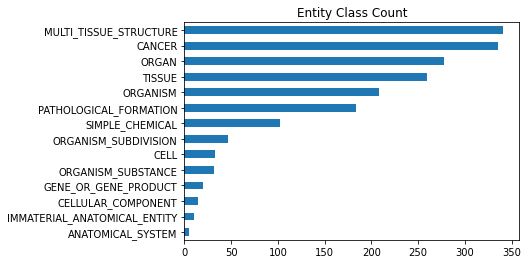

In [22]:
# checking count of classes

ent_table['class'].value_counts()[1:].sort_values(ascending=True).plot(kind='barh')

plt.title('Entity Class Count')

Text(0.5, 1.0, 'Multi-Tissue-Top Entities')

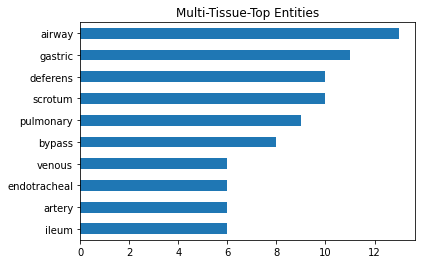

In [26]:
# Looking at the words which contribute to the top class 'MULTI_TISSUE_STRUCTURE'

multi_tissue_entity_s = ent_table[ent_table['class'] == 'MULTI_TISSUE_STRUCTURE']['ent'].astype('str')

multi_tissue_entity_s.value_counts().sort_values(ascending=True).tail(10).plot(kind='barh')

plt.title('Multi-Tissue-Top Entities')

In [27]:
def get_entity_options(ent_table,random_colors=False):
    """
    generating color options for visualizing the named entities
    """
    
    def color_generator(number_of_colors):
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
        return color

    entities = ent_table['class'].value_counts()[1:].index.tolist()
    
    colors = {"ENT":"#E8DAEF"}
    
    if random_colors:
        color = color_generator(len(entities))
        for i in range(len(entities)):
            colors[entities[i]] = color[i]
    else:
        entities_cat_1 = {"GGP":"#F9E79F", "SO":"#F7DC6F", "TAXON":"#F4D03F", "CHEBI":"#FAD7A0", "GO":"#F8C471", "CL":"#F5B041"}
        entities_cat_2 = {"DNA":"#82E0AA", "CELL_TYPE":"#AED6F1", "CELL_LINE":"#E8DAEF", "RNA":"#82E0AA", "PROTEIN":"#82E0AA"}
        entities_cat_3 = {"DISEASE":"#D7BDE2", "CHEMICAL":"#D2B4DE"}
        entities_cat_4 = {"CANCER":"#ABEBC6", "ORGAN":"#82E0AA", "TISSUE":"#A9DFBF", "ORGANISM":"#A2D9CE", "CELL":"#76D7C4", "AMINO_ACID":"#85C1E9", "GENE_OR_GENE_PRODUCT":"#AED6F1", "SIMPLE_CHEMICAL":"#76D7C4", "ANATOMICAL_SYSTEM":"#82E0AA", "IMMATERIAL_ANATOMICAL_ENTITY":"#A2D9CE", "MULTI-TISSUE_STRUCTURE":"#85C1E9", "DEVELOPING_ANATOMICAL_STRUCTURE":"#A9DFBF", "ORGANISM_SUBDIVISION":"#58D68D", "CELLULAR_COMPONENT":"#7FB3D5"}

        entities_cats = [entities_cat_1, entities_cat_2, entities_cat_3, entities_cat_4]
        for item in entities_cats:
            colors = {**colors, **item}
    
    options = {"ents": entities, "colors": colors}
    
    return options

get_entity_options(ent_table)

{'ents': ['MULTI_TISSUE_STRUCTURE',
  'CANCER',
  'ORGAN',
  'TISSUE',
  'ORGANISM',
  'PATHOLOGICAL_FORMATION',
  'SIMPLE_CHEMICAL',
  'ORGANISM_SUBDIVISION',
  'CELL',
  'ORGANISM_SUBSTANCE',
  'GENE_OR_GENE_PRODUCT',
  'CELLULAR_COMPONENT',
  'IMMATERIAL_ANATOMICAL_ENTITY',
  'ANATOMICAL_SYSTEM'],
 'colors': {'ENT': '#E8DAEF',
  'GGP': '#F9E79F',
  'SO': '#F7DC6F',
  'TAXON': '#F4D03F',
  'CHEBI': '#FAD7A0',
  'GO': '#F8C471',
  'CL': '#F5B041',
  'DNA': '#82E0AA',
  'CELL_TYPE': '#AED6F1',
  'CELL_LINE': '#E8DAEF',
  'RNA': '#82E0AA',
  'PROTEIN': '#82E0AA',
  'DISEASE': '#D7BDE2',
  'CHEMICAL': '#D2B4DE',
  'CANCER': '#ABEBC6',
  'ORGAN': '#82E0AA',
  'TISSUE': '#A9DFBF',
  'ORGANISM': '#A2D9CE',
  'CELL': '#76D7C4',
  'AMINO_ACID': '#85C1E9',
  'GENE_OR_GENE_PRODUCT': '#AED6F1',
  'SIMPLE_CHEMICAL': '#76D7C4',
  'ANATOMICAL_SYSTEM': '#82E0AA',
  'IMMATERIAL_ANATOMICAL_ENTITY': '#A2D9CE',
  'MULTI-TISSUE_STRUCTURE': '#85C1E9',
  'DEVELOPING_ANATOMICAL_STRUCTURE': '#A9DFBF',
  'ORG

In [28]:
# fit string into medspacy and display it

doc = med_nlp(concat_df6['med_str'][6])

options = get_entity_options(ent_table)

displacy.render(doc, style='ent', options=options)

In [29]:
# creating dataframe to insert into brat

brat_table = pd.DataFrame(doc.to_json()['ents'])

brat_table['ents'] = ['\t'+ str(ent) for ent in doc.ents]
brat_table['label'] = '\t'+ brat_table['label']

brat_table['brat_tag'] = ['T' + str(i) for i in brat_table.index]
brat_table['start'] = [' ' + str(i) for i in brat_table.start]
brat_table['end'] = [' ' + str(i) for i in brat_table.end]

brat_table_2 = brat_table[['brat_tag','label','start','end','ents']]

brat_table_2[:3]

,brat_tag,label,start,end,ents
0,T0,\tORGAN,27,34,\tabdomen
1,T1,\tTISSUE,81,92,\tsoft tissue
2,T2,\tORGANISM_SUBDIVISION,135,146,\tliposuction


In [329]:
# saving annotations to local folder

#np.savetxt('/Users/user_1/Desktop/brat_annotations/test.ann', brat_table_2.values, fmt='%s', delimiter = '')

In [330]:
# saving text file to local folder

#np.savetxt('/Users/user_1/Desktop/brat_annotations/test.txt',pd.Series(concat_df6.loc[6]['med_str']), fmt='%s')

In [378]:
#below is a sample of how u can insert lines into txt files

# f = open('/Users/user_1/Desktop/a_2.txt','r')

# contents = f.readlines()

# f.close()

# contents.insert(2,'a\n')

# f = open('/Users/user_1/Desktop/a_2.txt','w')

# contents = ''.join(contents)

# f.write(contents)

# f.close()